## Usage of Mapillary Data:

   -[Mapilary Dataset Github Repo](https://github.com/mapillary/mapillary_sls)
   
   -[Mapillary Pytorch Git](https://github.com/mapillary/mapillary_sls/blob/master/datasets/msls.py)
    
   -[Mapilary Demo](https://github.com/mapillary/mapillary_sls/blob/master/demo.ipynb)
   
   - [Mapilary Research Paper](https://research.mapillary.com/img/publications/CVPR20c.pdf)
   
   - [Mapillary suplementary material](https://research.mapillary.com/img/publications/CVPR20c_supp.pdf)
   
   -[Oslandia](https://github.com/Oslandia/deeposlandia)
        

## Tutorials

[Tensor Flow Load Images Tutorial](https://www.tensorflow.org/tutorials/load_data/images)

[Tensor Flow Image Classification Tutorial](https://www.tensorflow.org/tutorials/images/classification)

[Pillow](https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/)

In [1]:
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np
import os
import shutil
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Sample n images per sequence and resstructure folder

### Set directory of files and select cities

In [0]:
select = ['moscow','berlin','bangkok']

In [0]:
root_folder = Path('/Users/Arad/ITC/Final Project/Mapillary/train_val/')
sample_output_dir = Path('/Users/Arad/ITC/Final Project/Samples/')

cities_path = glob.glob(str(root_folder / '*'))
cities = [file_name.split('/')[-1] for file_name in cities_path]
idxs = [3,4,6,10,16,19,21,22,23] # these are indexes of citie with many images 
# select_cities = [cities[i] for i in idxs]
select_cities = ['moscow','berlin','bangkok']

### Sample Images from dataset - n images per sequence

In [0]:
def sample_images(city,root_folder,output_folder,n=5):
    
    db_path = root_folder / city / 'database'
    query_path = root_folder / city / 'query'

    ## sample from both database and query folders
    seq_database = pd.read_csv(db_path / 'seq_info.csv')
    seq_query = pd.read_csv(query_path / 'seq_info.csv')

    db_keys,q_keys = [],[]
    for seq in seq_database.sequence_key.value_counts().index:
        db_keys += seq_database[seq_database.sequence_key==seq].sample(n=n,replace=True).key.to_list()

    for seq in seq_query.sequence_key.value_counts().index:
        q_keys += seq_query[seq_query.sequence_key==seq].sample(n=n,replace=True).key.to_list()


    db_sample = [str(db_path / 'images/' / filename) + '.jpg' for filename in db_keys]
    q_sample = [str(query_path / 'images/' / filename) + '.jpg' for filename in q_keys]

    sample = db_sample+q_sample

    ## copy files to new folder
    sample_output_dir = output_folder
    dest = sample_output_dir+city
    Path(dest).mkdir(parents=True,exist_ok=True)

    for file_name in sample:
        if os.path.isfile(file_name):
            shutil.copy(file_name, dest)
    print(city,'files were copied to the sample output directory')
    

In [0]:
for city in select_cities:
    sample_images(city,root_folder,sample_output_dir,n=5)

FileNotFoundError: ignored

### Split files to train, validation and test folders

In [0]:
def split_train_test_val(city,sample_root_folder=sample_output_dir,train_size=0.6):
    
    file_names = glob.glob(str(sample_root_folder / city / "*"))

    num_train = round(train_size*len(file_names))

    ## shuffle file names 
    random.shuffle(file_names)

    train_dest = sample_root_folder / 'train' / city
    val_dest = sample_root_folder / 'val' / city
    test_dest = sample_root_folder / 'test' / city

    Path(train_dest).mkdir(parents=True,exist_ok=True)
    Path(val_dest).mkdir(parents=True,exist_ok=True)
    Path(test_dest).mkdir(parents=True,exist_ok=True)

    # move train files to train folder
    train_files = file_names[:num_train]

    for file_name in train_files:
        if os.path.isfile(file_name):
            shutil.move(file_name, train_dest/ file_name.split('/')[-1])

    val_test_index = (len(file_names)-num_train)//2

    # move val files to val folder
    val_files = file_names[num_train:num_train+val_test_index]

    for file_name in val_files:
        if os.path.isfile(file_name):
            shutil.move(file_name, val_dest / file_name.split('/')[-1])

    test_files = file_names[num_train+val_test_index:]

    for file_name in test_files:
        if os.path.isfile(file_name):
            shutil.move(file_name, test_dest / file_name.split('/')[-1])
    print(f"{city} has {len(file_names)} images sampled, {num_train} saved in train folder, {len(val_files)} in val and {len(test_files)} in test")


In [0]:
for city in select_cities:
    split_train_test_val(city)

melbourne has 706 images sampled, 424 saved in train folder, 141 in val and 141 in test
moscow has 28009 images sampled, 16805 saved in train folder, 5602 in val and 5602 in test
helsinki has 5938 images sampled, 3563 saved in train folder, 1187 in val and 1188 in test
phoenix has 9668 images sampled, 5801 saved in train folder, 1933 in val and 1934 in test
budapest has 17132 images sampled, 10279 saved in train folder, 3426 in val and 3427 in test
berlin has 8456 images sampled, 5074 saved in train folder, 1691 in val and 1691 in test
saopaulo has 5758 images sampled, 3455 saved in train folder, 1151 in val and 1152 in test
ottawa has 8779 images sampled, 5267 saved in train folder, 1756 in val and 1756 in test
bangkok has 6902 images sampled, 4141 saved in train folder, 1380 in val and 1381 in test


## RandomForest - GreyScale model

### Get all cities filenames per set

In [0]:
train_images,val_images,test_images = [],[],[]
for city in select_cities:
    train_images += glob.glob(str(sample_output_dir / 'train' /city / "*"))
    val_images += glob.glob(str(sample_output_dir / 'val' /city / "*"))
    test_images += glob.glob(str(sample_output_dir / 'test' /city / "*"))

In [0]:
len(train_images),len(val_images),len(test_images)

(26020, 16991, 16947)

### Preprocess images - resize, crop and save labels

In [0]:
def read_and_process_image(list_of_images,list_of_cities):
    X = [] # images
    y = [] # lables

    for i, image in enumerate(list_of_images):
        try:
            X.append(cv2.resize(cv2.imread(image,cv2.IMREAD_GRAYSCALE)[:380, :], (150, 150)).ravel())
            for j,city in enumerate(list_of_cities):
                if city == image.split('/')[-2]:
                    y.append(j)
        except TypeError as e:
            print(e,'on index',i)

    return np.array(X), np.array(y)

In [0]:
X_train,y_train = read_and_process_image(train_images,select_cities)

In [0]:
X_val,y_val = read_and_process_image(val_images,select_cities)

In [0]:
X_test,y_test = read_and_process_image(test_images,select_cities)

### examine sets

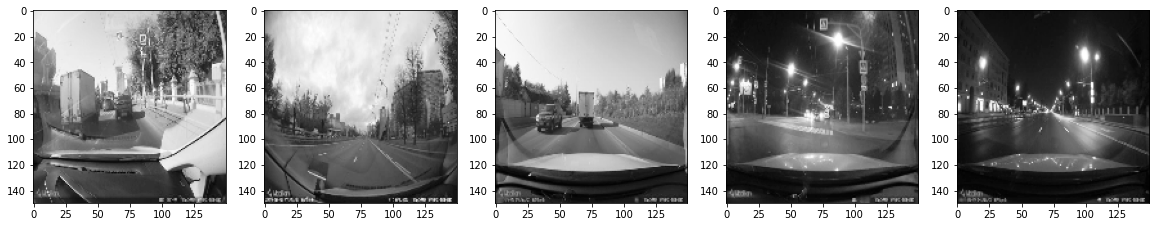

In [0]:
plt.figure(figsize=(20,10))
col = 5
for i in range(col):
    plt.subplot(5/col+1, col, i+1)
    plt.imshow(X_train[i].reshape(150,150), cmap='Greys_r')

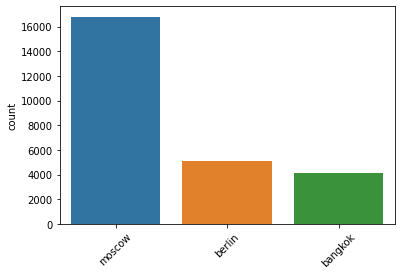

In [0]:
sns.countplot(y_train)
plt.xticks(range(len(select_cities)),labels=select_cities,rotation=45);

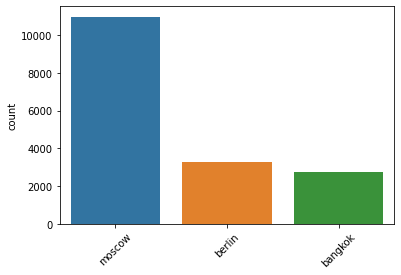

In [0]:
sns.countplot(y_val)
plt.xticks(range(len(select_cities)),labels=select_cities,rotation=45);

### Train random forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [0]:
## gridSearch - too heavy
# params = {'min_impurity_decrease': [10**-3,10**-4,10**-5],'min_samples_leaf':[2,5,10]}
# gs = GridSearchCV(RandomForestClassifier(),params,scoring='average_precision',verbose=10,n_jobs=-1)
# best_clf = gs.fit(np.concatenate([X_train,X_val]),np.concatenate([y_train,y_val]))
# best_clf.score(X_val, y_val)

In [0]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rfc.score(X_val, y_val)

0.8762874462950974

### evaluate model

In [0]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [0]:
print(classification_report(y_val, rfc.predict(X_val),target_names=select_cities))

              precision    recall  f1-score   support

      moscow       0.97      0.89      0.93     10977
      berlin       0.68      0.88      0.77      3288
     bangkok       0.85      0.80      0.83      2726

    accuracy                           0.88     16991
   macro avg       0.83      0.86      0.84     16991
weighted avg       0.89      0.88      0.88     16991



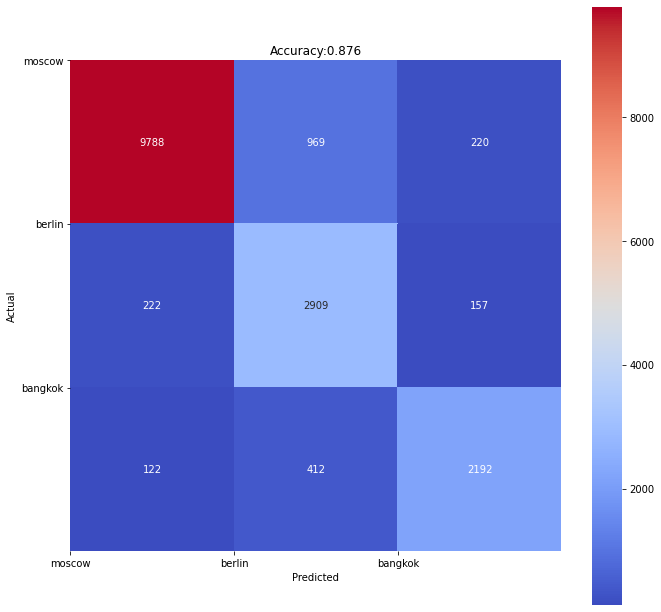

In [0]:
plt.figure(figsize=(11,11))
sns.heatmap(confusion_matrix(y_val, rfc.predict(X_val)), annot=True, fmt='g',cmap = 'coolwarm',square=True)
plt.xticks(range(len(select_cities)),labels=select_cities)
plt.yticks(range(len(select_cities)),labels=select_cities,rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Accuracy:{round(accuracy_score(y_val, rfc.predict(X_val)),3)}');

## Deep Learning - TF Convolutional Network

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

create generators

In [0]:
batch_size = 128
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [0]:
train_dir = sample_output_dir / 'train'
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH)
                                                          )

Found 26020 images belonging to 3 classes.


In [0]:
validation_dir = sample_output_dir / 'val'
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH)
                                                              )

Found 16991 images belonging to 3 classes.


In [0]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(len(select_cities),activation='sigmoid')
])

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],)

In [0]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 20736)           

In [0]:
# history = model.fit(
#     train_data_gen,
#     steps_per_epoch= len(train_images) // batch_size,
#     epochs=epochs,
#     validation_data=val_data_gen,validation_steps=len(val_images) // batch_size
# )

In [0]:
history = model.fit(
    train_data_gen,
    steps_per_epoch= 6,
    epochs=epochs,
    validation_data=val_data_gen,validation_steps=3
)

Epoch 1/10
6/6 [==============================] - 19s 3s/step - loss: 0.9217 - accuracy: 0.6406 - val_loss: 0.9174 - val_accuracy: 0.6432
Epoch 2/10
6/6 [==============================] - 20s 3s/step - loss: 0.9280 - accuracy: 0.6302 - val_loss: 0.9264 - val_accuracy: 0.6328
Epoch 3/10
6/6 [==============================] - 20s 3s/step - loss: 0.9125 - accuracy: 0.6458 - val_loss: 0.9217 - val_accuracy: 0.6354
Epoch 4/10
6/6 [==============================] - 24s 4s/step - loss: 0.9223 - accuracy: 0.6354 - val_loss: 0.9515 - val_accuracy: 0.6016
Epoch 5/10
6/6 [==============================] - 25s 4s/step - loss: 0.9088 - accuracy: 0.6484 - val_loss: 0.9161 - val_accuracy: 0.6406
Epoch 6/10
6/6 [==============================] - 28s 5s/step - loss: 0.9058 - accuracy: 0.6497 - val_loss: 0.8981 - val_accuracy: 0.6589
Epoch 7/10
6/6 [==============================] - 29s 5s/step - loss: 0.8987 - accuracy: 0.6576 - val_loss: 0.9214 - val_accuracy: 0.6328
Epoch 8/10
6/6 [==================

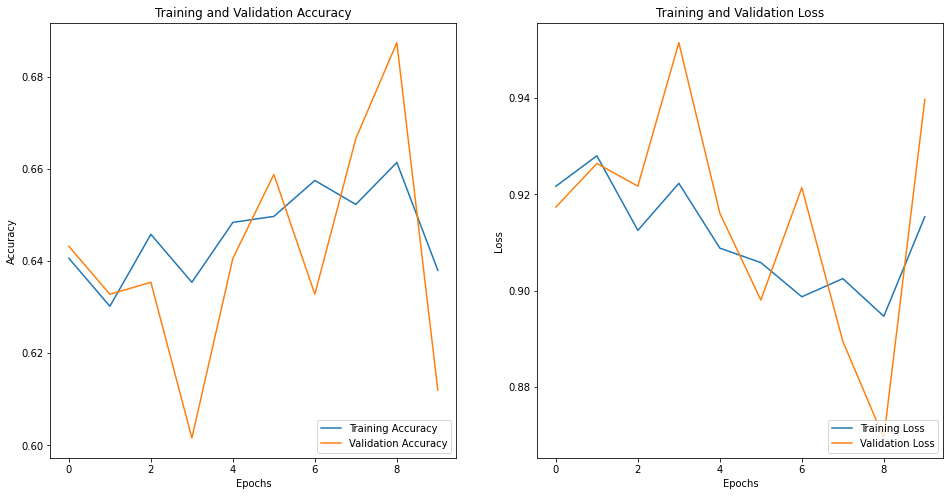

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

## Deep Learning - Transfer learning with imageNet